In [2]:
import csv
import pandas as pd
import hvplot.pandas
import matplotlib.pyplot as plt
from pprint import pprint
import kagglehub
import os
import requests
import pickle
from dotenv import load_dotenv


# Download latest version
path = kagglehub.dataset_download("nelgiriyewithana/most-streamed-spotify-songs-2024")
# Load data if it is not already loaded
if not os.path.exists(os.path.join("data", "spotify.csv")):
    file_name = os.listdir(path)[0]
    os.rename(os.path.join(path, file_name), os.path.join("data", "spotify.csv"))

# Load to dataframe
spotify_df = pd.read_csv("data/spotify.csv", encoding='ISO-8859-1')

# Clean up column names
for i in spotify_df.columns:
    spotify_df.rename(columns={i: (i.lower()).replace(" ", "_")}, inplace=True)

# Save to pickle   
pickle_path = os.path.join("data", "spotify_df.pkl")
spotify_df.to_pickle(pickle_path)

## Data Cleaning

In [3]:
clean_df = spotify_df.drop(columns=['tidal_popularity'])
clean_df = clean_df.dropna()
for i in clean_df.columns:
    clean_df.rename(columns={i: (i.lower()).replace(" ", "_")}, inplace=True)
clean_df.head()

,track,album_name,artist,release_date,isrc,all_time_rank,track_score,spotify_streams,spotify_playlist_count,spotify_playlist_reach,...,airplay_spins,siriusxm_spins,deezer_playlist_count,deezer_playlist_reach,amazon_playlist_count,pandora_streams,pandora_track_stations,soundcloud_streams,shazam_counts,explicit_track
0,MILLION DOLLAR BABY,Million Dollar Baby - Single,Tommy Richman,4/26/2024,QM24S2402528,1,725.4,"390,470,936","30,716","196,631,588",...,"40,975",684,62.0,"17,598,718",114.0,"18,004,655","22,931","4,818,457","2,669,262",0
1,Not Like Us,Not Like Us,Kendrick Lamar,5/4/2024,USUG12400910,2,545.9,"323,703,884","28,113","174,597,137",...,"40,778",3,67.0,"10,422,430",111.0,"7,780,028","28,444","6,623,075","1,118,279",1
2,i like the way you kiss me,I like the way you kiss me,Artemas,3/19/2024,QZJ842400387,3,538.4,"601,309,283","54,331","211,607,669",...,"74,333",536,136.0,"36,321,847",172.0,"5,022,621","5,639","7,208,651","5,285,340",0
5,Lovin On Me,Lovin On Me,Jack Harlow,11/10/2023,USAT22311371,6,410.1,"670,665,438","105,892","175,421,034",...,"522,042","4,654",86.0,"17,167,254",152.0,"138,529,362","50,982","9,438,601","4,517,131",1
9,BAND4BAND (feat. Lil Baby),BAND4BAND (feat. Lil Baby),Central Cee,5/23/2024,USSM12404354,10,330.6,"90,676,573","10,400","184,199,419",...,"3,823",117,78.0,"10,800,098",92.0,"1,005,626",842,"3,679,709","666,302",1


In [3]:
# Load the .env file
load_dotenv()
lastfm_id = os.getenv("lastfm_id")
lastfm_secret = os.getenv("lastfm_secret")

lastfm_url = 'http://ws.audioscrobbler.com/2.0/'
parameters = {
    'method': 'track.getTopTags',
    'api_key': lastfm_id,
    'format': 'json',
    'autocorrect': 1
}

if os.path.exists(pickle_path):
    with open(pickle_path, 'wb') as file:
        spotify_df = pickle.load(file)
        if 'lastfm_tags' not in spotify_df.columns:
            spotify_df['lastfm_tags'] = None
        else: 
            for index, row in spotify_df[spotify_df['lastfm_tags'].apply(lambda x: x == [] or x == None)].iterrows():
                parameters['track'] = row['track']
                parameters['artist'] = row['artist']
                r = requests.get(lastfm_url, params=parameters).json()
                try:
                    tags = [tag['name'] for tag in r['toptags']['tag']]
                except KeyError:
                    print(f"Error with {row['track']} by {row['artist']}")
                    pprint(r)
                    tags = []
                spotify_df.at[index, 'lastfm_tags'] = tags
else:
    print("no pickle found: creating one now") 
    pickle.dump(spotify_df, file)

UnsupportedOperation: read

In [15]:
# Load the .env file
load_dotenv()

spotify_id = os.getenv("spotify_id")
spotify_secret = os.getenv("spotify_secret")


auth_url = "https://accounts.spotify.com/api/token"
auth_response  = requests.post(auth_url, {
    'grant_type': 'client_credentials',
    'client_id': spotify_id,
    'client_secret': spotify_secret,
})

#Convert response to JSON
auth_response_data = auth_response.json()

#Save the access token
access_token = auth_response_data['access_token']

#Need to pass access token into header to send properly formed GET request to API server
headers = {
    'Authorization': 'Bearer {token}'.format(token=access_token)
}

base_url = 'https://api.spotify.com/v1/'

if os.path.exists(path=pickle_path):
    with open(pickle_path, 'rb') as file:
        spotify_df = pickle.load(file)
        if 'spotify_id' not in spotify_df.columns:
            spotify_df['spotify_id'] = None
        for index, row in spotify_df.iterrows():
            if row['spotify_id'] == None:
                parameters = {
                'q': 'isrc:'+row['isrc'],
                'type': 'track',
                'limit' : 1
            }
                try:
                    r = requests.get(base_url + 'search', headers=headers, params=parameters).json()
                    spotify_id = r['tracks']['items'][0]['id']
                    print(f'processing row: {index} --- adding {spotify_id} as spotify_id' )
                    spotify_df.at[index, 'spotify_id'] = r['tracks']['items'][0]['id']
                except IndexError:
                    print(f"track not found by isrc: {row['isrc']}")
                    print(f'trying by track and artist: {row["track"]} by {row["artist"]}')
                    parameters = {
                        'q': f'track:{row["track"]}+artist:{row["artist"]}',
                        'type': 'track',
                        'limit' : 1
                    }
                    r = requests.get(base_url + 'search', headers=headers, params=parameters).json()
                    try:
                        spotify_id = r['tracks']['items'][0]['id']
                        print(f'processing row: {index} --- adding {spotify_id} as spotify_id' )
                        spotify_df.at[index, 'spotify_id'] = r['tracks']['items'][0]['id']
                    except IndexError:
                        print(f"track not found by track and artist: {row['track']} by {row['artist']}")
                        print(f"giving up")
                        spotify_df.at[index, 'spotify_id'] = None
else:
    print("no pickle found: creating one now") 
    pickle.dump(spotify_df, file)

processing row: 0 --- adding 5AJ9hqTS2wcFQCELCFRO7A as spotify_id
processing row: 1 --- adding 6AI3ezQ4o3HUoP6Dhudph3 as spotify_id
processing row: 2 --- adding 2GxrNKugF82CnoRFbQfzPf as spotify_id
processing row: 3 --- adding 7DSAEUvxU8FajXtRloy8M0 as spotify_id
processing row: 4 --- adding 2HYFX63wP3otVIvopRS99Z as spotify_id
processing row: 5 --- adding 4xhsWYTOGcal8zt0J161CU as spotify_id
processing row: 6 --- adding 3xkHsmpQCBMytMJNiDf3Ii as spotify_id
processing row: 7 --- adding 6XjDF6nds4DE2BBbagZol6 as spotify_id
processing row: 8 --- adding 6KD131fI0hLfrb7Uwa6jCw as spotify_id
processing row: 9 --- adding 7iabz12vAuVQYyekFIWJxD as spotify_id
processing row: 10 --- adding 5IZXB5IKAD2qlvTPJYDCFB as spotify_id
processing row: 11 --- adding 4yq8Oc51K2mgLfo9BjU3Rr as spotify_id
processing row: 12 --- adding 629DixmZGHc7ILtEntuiWE as spotify_id
processing row: 13 --- adding 2tudvzsrR56uom6smgOcSf as spotify_id
processing row: 14 --- adding 5JvEHdLTVmD6I9a3EMoOjL as spotify_id
proce

In [ ]:
# Load the .env file
load_dotenv()

spotify_id = os.getenv("spotify_id")
spotify_secret = os.getenv("spotify_secret")


auth_url = "https://accounts.spotify.com/api/token"
auth_response  = requests.post(auth_url, {
    'grant_type': 'client_credentials',
    'client_id': spotify_id,
    'client_secret': spotify_secret,
})

#Convert response to JSON
auth_response_data = auth_response.json()

#Save the access token
access_token = auth_response_data['access_token']

#Need to pass access token into header to send properly formed GET request to API server
headers = {
    'Authorization': 'Bearer {token}'.format(token=access_token)
}

base_url = 'https://api.spotify.com/v1/'

pickle_path = os.path.join("data", "spotify_df.pkl")

if os.path.exists(pickle_path):
    with open(pickle_path, 'rb') as file:
        spotify_df = pickle.load(file)
        if 'spotify_features' not in spotify_df.columns:
            spotify_df['spotify_features'] = None
        for index, row in spotify_df.iterrows():
            if row['spotify_features'] == None:
                try:
                    r = requests.get(base_url + 'audio-features/' + row['spotify_id'], headers=headers).json()
                    spotify_df.at[index, 'spotify_features'] = r
                except (requests.exceptions.RequestException, KeyError, IndexError) as e:
                    print(f"Error with {row['spotify_id']}: ( {row['track']} by {row['artist']} ) \n {e}")
                    spotify_df.at[index, 'spotify_features'] = None
else:
    print("no pickle found: creating one now") 
    pickle.dump(spotify_df, file)

In [ ]:
df = spotify_df[spotify_df['lastfm_tags'].apply(lambda x: x != [])]
df.reset_index(inplace=True)
df.rename(columns={'index': 'original_rank'}, inplace=True)

In [7]:
def tag_frequency(tag, df):
    """
    Calculate the frequency of a specific tag in the DataFrame.

    Parameters:
    tag (str): The tag to search for in the 'lastfm_tags' column.
    df (pd.DataFrame): The DataFrame containing the 'lastfm_tags' column.

    Returns:
    int: The number of occurrences of the specified tag in the DataFrame.
    
    Example usage:
    tag = 'Hip-Hop'
    frequency = tag_frequency(tag, spotify_df)
    print(f"The tag '{tag}' appears {frequency} times in the lastfm_tags column.")
    """
    return df['lastfm_tags'].apply(lambda x: tag in x).sum() # df['lastfm_tags'].apply(lambda x: tag in x) returns a boolean series with true for each row that contains the tag 

all_tags = spotify_df['lastfm_tags'].explode().unique()

tag_frequency_df = pd.DataFrame({'tag': all_tags, 'frequency': [tag_frequency(tag, df) for tag in all_tags]})

tag_frequency_df.sort_values('frequency', ascending=False, inplace=True)
tag_frequency_df

TypeError: argument of type 'NoneType' is not iterable

## Exploratory Analysis

In [4]:
for col in clean_df.columns:
    print(f"{col}")

track
album_name
artist
release_date
isrc
all_time_rank
track_score
spotify_streams
spotify_playlist_count
spotify_playlist_reach
spotify_popularity
youtube_views
youtube_likes
tiktok_posts
tiktok_likes
tiktok_views
youtube_playlist_reach
apple_music_playlist_count
airplay_spins
siriusxm_spins
deezer_playlist_count
deezer_playlist_reach
amazon_playlist_count
pandora_streams
pandora_track_stations
soundcloud_streams
shazam_counts
explicit_track


In [7]:
# View the number of rows and columns
clean_df.shape

(565, 28)

In [8]:
# View columns and their data types
clean_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 565 entries, 0 to 4590
Data columns (total 28 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   track                       565 non-null    object 
 1   album_name                  565 non-null    object 
 2   artist                      565 non-null    object 
 3   release_date                565 non-null    object 
 4   isrc                        565 non-null    object 
 5   all_time_rank               565 non-null    object 
 6   track_score                 565 non-null    float64
 7   spotify_streams             565 non-null    object 
 8   spotify_playlist_count      565 non-null    object 
 9   spotify_playlist_reach      565 non-null    object 
 10  spotify_popularity          565 non-null    float64
 11  youtube_views               565 non-null    object 
 12  youtube_likes               565 non-null    object 
 13  tiktok_posts                565 non-nul

In [9]:
# View descriptive statistical data for columns
clean_df.describe()

,track_score,spotify_popularity,apple_music_playlist_count,deezer_playlist_count,amazon_playlist_count,explicit_track
count,565.000000,565.000000,565.000000,565.000000,565.000000,565.000000
mean,61.544425,69.722124,89.886726,42.557522,35.398230,0.405310
std,65.000014,11.175532,85.325438,59.133480,32.222118,0.491387
min,19.500000,6.000000,3.000000,1.000000,1.000000,0.000000
25%,28.100000,65.000000,32.000000,9.000000,13.000000,0.000000
50%,40.700000,71.000000,63.000000,26.000000,27.000000,0.000000
75%,69.700000,76.000000,122.000000,54.000000,45.000000,1.000000
max,725.400000,95.000000,859.000000,584.000000,188.000000,1.000000


## STATISTICAL ANALYSIS

In [10]:
# Convert relevant columns to numeric by removing commas if present
columns_to_convert = ['all_time_rank','tiktok_views','spotify_streams','spotify_playlist_count','airplay_spins','siriusxm_spins','tiktok_posts','tiktok_likes','youtube_views','pandora_streams']
for column in columns_to_convert:
    clean_df[column] = clean_df[column].str.replace(',', '').astype(float)
    print(clean_df[column].dtypes)

float64
float64
float64
float64
float64
float64
float64
float64
float64
float64


### Are Airplay spins related to Spotify Popularity?

Spotify Popularity and Airplay Spins Correlation  Matrix:
                    airplay_spins  spotify_popularity
airplay_spins                1.00                0.17
spotify_popularity           0.17                1.00


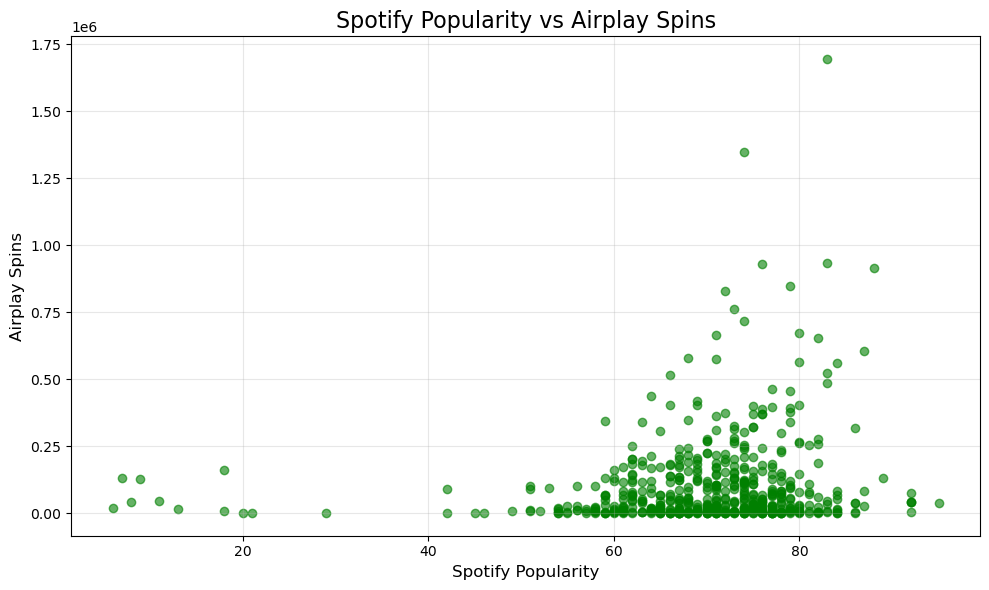

In [15]:
# Comparing Spotify Popularity to Airplay Spins
correlation_spotify_matrix = clean_df[['airplay_spins','spotify_popularity']].corr()
print("Spotify Popularity and Airplay Spins Correlation  Matrix:")
print(round(correlation_spotify_matrix, 2))

if 'spotify_popularity' in clean_df.columns and 'airplay_spins' in clean_df.columns:
    plt.figure(figsize=(10, 6))

    # Scatter plot
    plt.scatter(clean_df['spotify_popularity'], clean_df['airplay_spins'], alpha=0.6, color='green')
    
    plt.title('Spotify Popularity vs Airplay Spins', fontsize=16)
    plt.xlabel('Spotify Popularity', fontsize=12)
    plt.ylabel('Airplay Spins', fontsize=12)

    # Add gridlines for better readability
    plt.grid(alpha=0.3)

    # Show the graph
    plt.tight_layout()
    plt.show()

### Analysis Summary:

The correlation matrix was generated to explore relationships between the following variables:

Spotify Popularity and Airplay spins

The chart shows a positive but weak correlation between Spotify Popularity and Airplay spins. This is verified by the calculation of the correlation coefficient of 0.17, showing that there is no strong correlation between the two data points.

### Key findings:

Spotify Popularity and Airplay spins showed a positive but weak correlation as verified with the calculation of the correlation coefficient.

### Visual Insights

- Spotify Popularity and Airplay spins:

A positive relationship is evident visually as the data looks to align with each other.


## How does TikTok virality (posts/likes/views) influence other platform metrics like Spotify streams or YouTube views?

Correlation Matrix:
                 tiktok_views  spotify_streams  tiktok_posts  tiktok_likes  \
tiktok_views             1.00             0.21          0.66          0.95   
spotify_streams          0.21             1.00          0.28          0.22   
tiktok_posts             0.66             0.28          1.00          0.61   
tiktok_likes             0.95             0.22          0.61          1.00   
youtube_views            0.09             0.65          0.22          0.05   

                 youtube_views  
tiktok_views              0.09  
spotify_streams           0.65  
tiktok_posts              0.22  
tiktok_likes              0.05  
youtube_views             1.00  

Summary of Correlations:
tiktok_views shows strong positive correlations with: tiktok_views, tiktok_posts, tiktok_likes
spotify_streams shows strong positive correlations with: spotify_streams, youtube_views
tiktok_posts shows strong positive correlations with: tiktok_views, tiktok_posts, tiktok_likes
tiktok_li

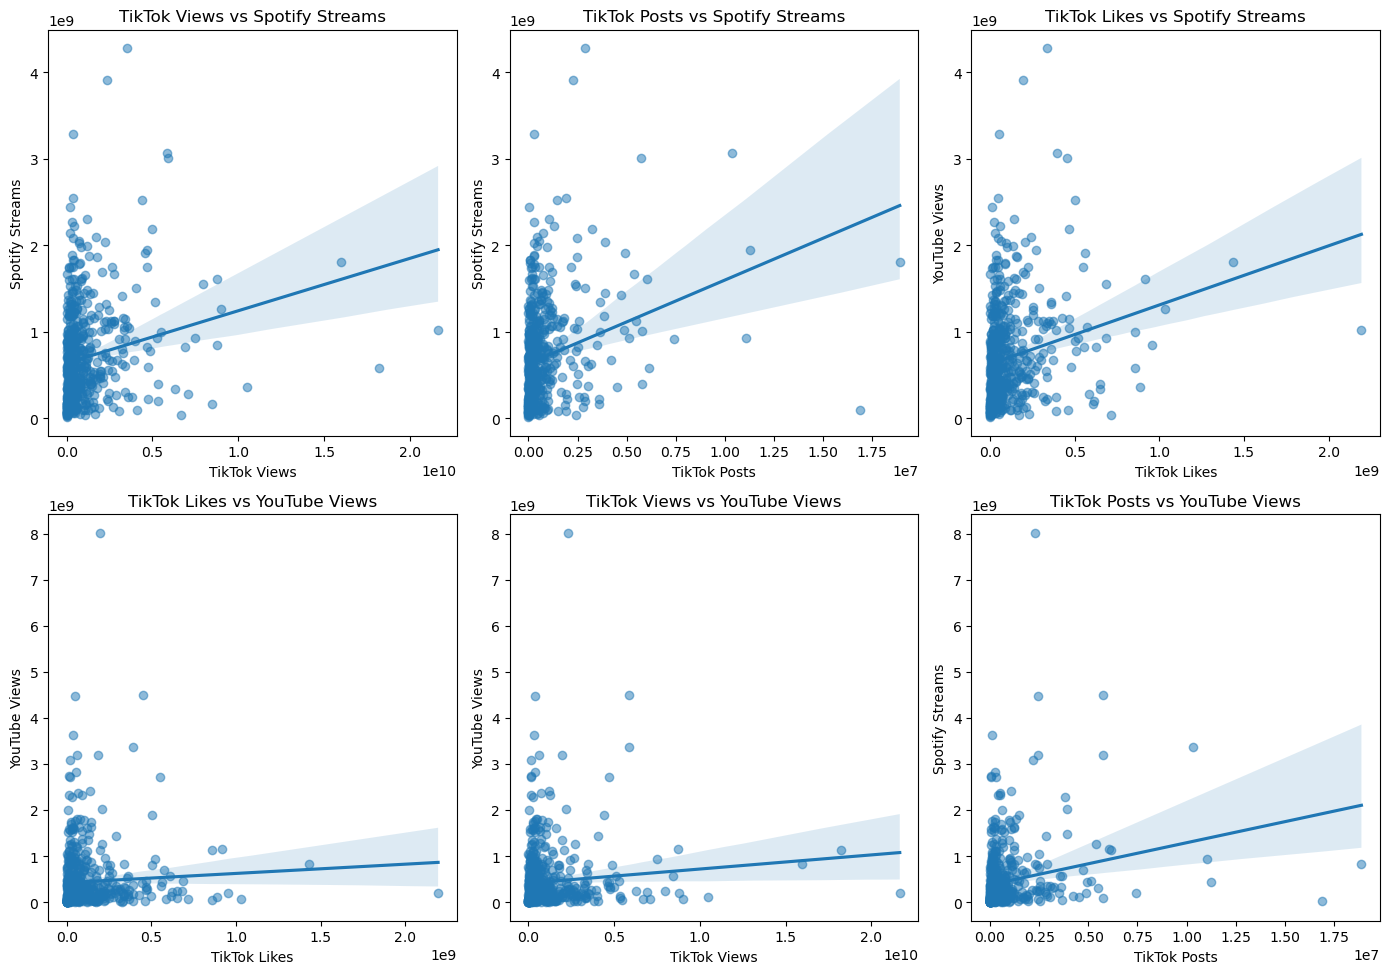

In [17]:
import seaborn as sns
import numpy as np
# Create a correlation matrix
correlation_tiktok_matrix = clean_df[['tiktok_views','spotify_streams','tiktok_posts','tiktok_likes','youtube_views']].corr()
print("Correlation Matrix:")
print(round(correlation_tiktok_matrix, 2))

# Brief summary of correlation findings
print("\nSummary of Correlations:")
for col in correlation_tiktok_matrix.columns:
    significant_correlations = correlation_tiktok_matrix[col][correlation_tiktok_matrix[col] > 0.5]
    print(f"{col} shows strong positive correlations with: {', '.join(significant_correlations.index)}")

# Visualization: How TikTok virality influences other platform metrics
plt.figure(figsize=(14, 10))

# Scatter plot for TikTok Views vs Spotify Streams
plt.subplot(2, 3, 1)
sns.regplot(data=clean_df, x='tiktok_views', y='spotify_streams', scatter_kws={"alpha": 0.5})
plt.title('TikTok Views vs Spotify Streams')
plt.xlabel('TikTok Views')
plt.ylabel('Spotify Streams')

# Scatter plot for TikTok Posts vs Spotify Streams
plt.subplot(2, 3, 2)
sns.regplot(data=clean_df, x='tiktok_posts', y='spotify_streams', scatter_kws={"alpha": 0.5})
plt.title('TikTok Posts vs Spotify Streams')
plt.xlabel('TikTok Posts')
plt.ylabel('Spotify Streams')

# Scatter plot for TikTok Likes vs YouTube Views
plt.subplot(2, 3, 3)
sns.regplot(data=clean_df, x='tiktok_likes', y='spotify_streams', scatter_kws={"alpha": 0.5})
plt.title('TikTok Likes vs Spotify Streams')
plt.xlabel('TikTok Likes')
plt.ylabel('YouTube Views')

# Scatter plot for TikTok Likes vs YouTube Views
plt.subplot(2, 3, 4)
sns.regplot(data=clean_df, x='tiktok_likes', y='youtube_views', scatter_kws={"alpha": 0.5})
plt.title('TikTok Likes vs YouTube Views')
plt.xlabel('TikTok Likes')
plt.ylabel('YouTube Views')

# Scatter plot for TikTok Views vs YouTube Views
plt.subplot(2, 3, 5)
sns.regplot(data=clean_df, x='tiktok_views', y='youtube_views', scatter_kws={"alpha": 0.5})
plt.title('TikTok Views vs YouTube Views')
plt.xlabel('TikTok Views')
plt.ylabel('YouTube Views')

# Scatter plot for TikTok Posts vs Spotify Streams
plt.subplot(2, 3, 6)
sns.regplot(data=clean_df, x='tiktok_posts', y='youtube_views', scatter_kws={"alpha": 0.5})
plt.title('TikTok Posts vs YouTube Views')
plt.xlabel('TikTok Posts')
plt.ylabel('Spotify Streams')

plt.tight_layout()
plt.show()

### Analysis Summary

The correlation matrix was generated to explore relationships between the following variables:

Spotify Streams vs TikTok Views, TikTok Posts and TikTok Likes

YouTube Views vs TikTok Views, TikTok Posts and TikTok Likes

### Key findings:

Spotify Streams showed a strong positive correlations with YouTube Views.

### Visual Insights

- TikTok Views vs Spotify Streams:

A positive relationship is evident. Higher TikTok Views tend to align with increased Spotify Streams.

The scatter plot indicates a potential linear trend.

- TikTok Posts vs Spotify Streams:

The number of TikTok Posts appears positively associated with Spotify Streams.

Outliers might represent songs that went viral with fewer posts but gained traction in Spotify streams.

- TikTok Likes vs YouTube Views:

Likes on TikTok correlate positively with YouTube Views, suggesting audience engagement on TikTok may spill over to YouTube.

The scatter plot demonstrates a consistent upward trend.

- TikTok Views vs YouTube Views:

A positive correlation is observed, indicating that higher TikTok Views may contribute to higher YouTube Views.



Spotify Streams and YouTube Views Correlation  Matrix:
                 youtube_views  spotify_streams
youtube_views             1.00             0.65
spotify_streams           0.65             1.00


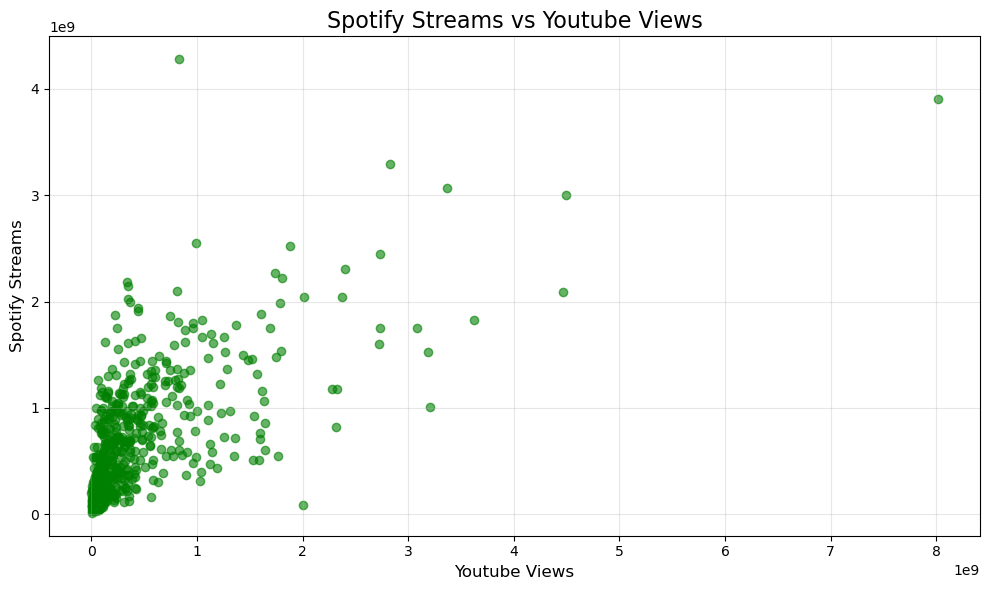

In [22]:
# Comparing Spotify Popularity to Airplay Spins
correlation_spotify_matrix = clean_df[['youtube_views','spotify_streams']].corr()
print("Spotify Streams and YouTube Views Correlation  Matrix:")
print(round(correlation_spotify_matrix, 2))

if 'youtube_views' in clean_df.columns and 'spotify_streams' in clean_df.columns:
    plt.figure(figsize=(10, 6))

    # Scatter plot
    plt.scatter(clean_df['youtube_views'], clean_df['spotify_streams'], alpha=0.6, color='green')
    
    plt.title('Spotify Streams vs Youtube Views', fontsize=16)
    plt.xlabel('Youtube Views', fontsize=12)
    plt.ylabel('Spotify Streams', fontsize=12)

    # Add gridlines for better readability
    plt.grid(alpha=0.3)

    # Show the graph
    plt.tight_layout()
    plt.show()

### Summary:

the chart shows a strong correlation between spotify streams and youtube views. This is verified by the calculation of the correlation coefficient of 0.65
### Analysis Summary

The correlation matrix was generated to explore relationships between the following variables:

Spotify Streams vs YouTube Views

### Key findings:

Spotify Streams showed a strong positive correlations with YouTube Views as verified with the calculation of the correlation coefficient.

### Visual Insights

- Spotify Streams vs YouTube Views:

A positive relationship is evident visually as the Spotify Streaming data looks to align with increased Youtube Views.

